# One-way ANOVA 

## 背景描述

为了调查吃巧克力对心血管健康的影响，实验由三种类型的巧克力组成：100g的黑巧克力，含有200mg全脂牛奶的100g黑巧克力和200g的牛奶巧克力。12个实验对象：7女5男。在不同的天数里，每个实验对象将吃一种类型的巧克力，一个小时后测量他们血浆的总抗氧能力。 

这是一个因子水平数 𝑎 = 3 和重复次数 𝑛 = 12 的单因子实验。

## 数据描述
实验次序本身具有随机性，无需再随机化

|       变量名        |  变量含义  |       变量类型       | 变量取值范围 |
| :-----------------: | :--------: | :------------------: | :----------: |
| （自变量）Chocolate | 巧克力类型 | categorical variable |  [1, 2, 3]   |
| （因变量）Capacity  |  血浆浓度  | continuous variable  |     Real     |

In [1]:
import pandas as pd
print(pd.read_csv('data/Project1.csv').values)

[[  1.    1.  118.8]
 [  2.    1.  122.6]
 [  3.    1.  115.6]
 [  4.    1.  113.6]
 [  5.    1.  119.5]
 [  6.    1.  115.9]
 [  7.    1.  115.8]
 [  8.    1.  115.1]
 [  9.    1.  116.9]
 [ 10.    1.  115.4]
 [ 11.    1.  115.6]
 [ 12.    1.  107.9]
 [  1.    2.  105.4]
 [  2.    2.  101.1]
 [  3.    2.  102.7]
 [  4.    2.   97.1]
 [  5.    2.  101.9]
 [  6.    2.   98.9]
 [  7.    2.  100. ]
 [  8.    2.   99.8]
 [  9.    2.  102.6]
 [ 10.    2.  100.9]
 [ 11.    2.  104.5]
 [ 12.    2.   93.5]
 [  1.    3.  102.1]
 [  2.    3.  105.8]
 [  3.    3.   99.6]
 [  4.    3.  102.7]
 [  5.    3.   98.8]
 [  6.    3.  100.9]
 [  7.    3.  102.8]
 [  8.    3.   98.7]
 [  9.    3.   94.7]
 [ 10.    3.   97.8]
 [ 11.    3.   99.7]
 [ 12.    3.   98.6]]


## 问题 
注：这里使用 \alpha=0.05 的显著性水平

1. 试判断食用的 3 种巧克力对心血管健康的影响是否有差异.
2. 试判断该实验用One-way ANOVA模型是否恰当.
3. 估计食用这 3 种巧克力 1h 后血浆的总抗氧能力均值和误差的方差.
4. 若Q1判断存在差异，请进行多重比较.

## 解决方案
**Q1:**  
检验假设 $H_0: \mu_1 = \mu_2 = \mu_3$ ;  $H_1: \mu_1, \mu_2, \mu_3$不全相等

In [2]:
# Import standard packages
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import math

In [3]:
# Import additional packages
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from scipy.stats import f

In [4]:
alpha = 0.05
a = 3
n = 12
x = pd.read_csv('data/Project1.csv')
data = x.values[:,1:3]
# print(data)

In [5]:
# Sort them into groups, according to column 1("Chocolate")
group1 = data[data[:,0] == 1,1]
group2 = data[data[:,0] == 2,1]
group3 = data[data[:,0] == 3,1]

In [6]:
# Do the one-way ANOVA
df = pd.DataFrame(data, columns = ['Chocolate', 'Capacity'])   
model = ols('Capacity ~ C(Chocolate)', df).fit()
anovaResults = round(anova_lm(model), 2)
print('The ANOVA table: \n', anovaResults)  

The ANOVA table: 
                 df   sum_sq  mean_sq      F  PR(>F)
C(Chocolate)   2.0  1952.64   976.32  93.58     0.0
Residual      33.0   344.31    10.43    NaN     NaN


In [7]:
F0, pVal1 = stats.f_oneway(group1, group2, group3)

In [8]:
# 法1：
# print(pVal1)
if pVal1 < alpha:
    print('\nSince p-value < 0.05, reject H0.')
else:
    print('\nAccept H0.') 


Since p-value < 0.05, reject H0.


In [9]:
# 法2：
F = round(f.ppf(0.95,dfn = 2,dfd = 33), 2)
if F0 > F:
    print('Since F0 > F(0.05,3,16) = ', F, ', reject H0.')
else:
    print('Accept H0.') 

Since F0 > F(0.05,3,16) =  3.28 , reject H0.


p-value小于 0.05 （F值大于 3.28），故拒绝原假设，即食用的 3 种巧克力对心血管健康的影响有差异。

**Q2:**  
ANOVA模型： 
$y_{ij} = \mu + \tau_i + \epsilon_{ij}$ 的误差服从正态独立分布，其均值为零，方差为未知的常数$\sigma^2$。

想要判断ANOVA模型是否恰当，可以利用残差检测来进行分析。  
处理 $i$ 的观测值 $j$ 的残差定义为：$e_{ij} = y_{ij} - \hat{y}_{ij}$  
其中$\hat{y}_{ij}$是对应于$y_{ij}$的一个估计， 
$\hat{y}_{ij} = \hat{\mu} + \hat{\tau}_i = \overline{y}_{··} + (\overline{y}_{i·} - \overline{y}_{··}) = \overline{y}_{i·}$  
  
**1. 独立性检验**  

In [10]:
# 计算血浆浓度的残差
data_res = data.astype(float)*1
list_c = [1,2,3]
for k in list_c:
    cnt = data_res[data_res[:,0] == k,1]
    data_res[data_res[:,0] == k,1] = cnt - np.mean(cnt)

【】利用Durbin-Watson检验，又称DW检验来做独立性检验。是用来检验分析中残差的一阶自相关性的。  
各残差的相关性方程为：$e_i = \rho * e_{i-1} + v_i$，检验的原假设为：$\rho = 0$，备择假设为：$\rho \neq 0$  
检验统计量为：$d = \frac{\sum^T_{t=2}\quad(e_i-e_{i-1})^2}{\sum^T_{t=1}\quad e_i^2}$  
该统计量值越接近 2 越好，一般在 1~3 之间说明没问题，小于 1 这说明残差存在自相关性（有临界值表可以查）。 

In [11]:
# 用Durbin-Watson检验进行独立性检验
def durbin_watson(residuals):
    nume = sum(np.diff(residuals.T) ** 2)
    deno = sum(residuals ** 2)
    return nume / deno
res = data_res[:, 1]
dw = durbin_watson(res)
print('Durbin-Watson检验的统计量为：', round(dw,2))

Durbin-Watson检验的统计量为： 2.3


由分析可知，Durbin-Watson检验的统计量为：2.3，在 1~3 之间，故没有违反独立性的假定。


**2. 方差齐性检验**  
【法1】Bartlett检验的核心思想是通过求取不同组之间的卡方统计量，然后根据卡方统计量的值来判断组间方差是否相等。该方法极度依赖于数据是正态分布，如果数据非正态分布，则的出来的结果偏差很大。  
Bartlett检验统计量为：$\chi_0^2 = 2.3026\frac{q}{c}$  
其中，$q = (N - a)log_{10}S_p^2 - \sum_{i=1}^a(n_i - 1)log_{10}S_i^2$  
$c = 1 + \frac{1}{3(a-1)}(\sum_{i=1}^a(n_i-1)^{-1} - (N - a)^{-1})$  
$S_p^2 = \frac{\sum_{i=1}^a\quad(n_i-1)S_i^2}{N - a}$ 且$S_i^2$是第 $i$ 个总体的样本方差；当$\chi_0^2 > \chi_{\alpha,a-1}^2$ 时，拒绝$H_0$，其中$\chi_{\alpha,a-1}^2$是自由度为$a-1$的卡方分布上的 $\alpha$ 分位数。

In [12]:
# 用Bartlett检验进行方差齐性检验
bart, pVal2 = stats.bartlett(group1, group2, group3)
bart_stat = stats.chi2.isf(alpha, a-1)

# 法1：
print('Bartlett检验的P值为：', round(pVal2, 2))
if pVal2 < alpha:
    print('Since p-value < 0.05, reject H0.')
else:
    print('Accept H0')  

# 法2：
print('Bartlett检验统计量：', round(bart, 2))
print('𝜒_(𝛼,𝑎−1)^2: ', round(bart_stat, 2))
if bart > bart_stat:
    print('Since 𝜒_0^2 > 𝜒_(𝛼,𝑎−1)^2, reject H0.')
else:
    print('Accept H0')  


Bartlett检验的P值为： 0.81
Accept H0
Bartlett检验统计量： 0.42
𝜒_(𝛼,𝑎−1)^2:  5.99
Accept H0


由分析可知，Bartlett检验的P值大于 0.05 且Bartlett检验统计量小于 5.99，故接受原假设，即残差具有方差齐性。  
  
【法2】Levene检验是将每个值先转换为该值与其组内均值的偏离程度，然后再用转换后的偏离程度去做方差分析，即组间方差/组内方差。修正后的Levene检验中的均值采用中位数的计算方法，因此这里的偏差用每个处理的观测值$y_{ij}$与该处理中的中位数$\tilde{y}_{i·}$的偏差的绝对值来表示：$d_{ij} = |y_{ij} - \tilde{y}_{i·}|, i = 1,2,···,a;j = 1,2,···,n$

In [13]:
# 用Levene检验进行方差齐性检验
lene, pVal3 = stats.levene(group1, group2, group3)
print('Levene检验的P值为：', round(pVal3, 2))
if pVal3 < alpha:
    print('Since p-value < 0.05, reject H0.')
else:
    print('Accept H0')  

Levene检验的P值为： 0.98
Accept H0


由分析可知，Levene检验的P值大于 0.05，故残差具有方差齐性。

**3. 正态性检验**  
【法1】利用qq图（The quantitle-quantile plot），来检验数据分布的相似性。令X轴为正态分布的分位数，Y轴为样本分位数，如果这两者构成的点分布在一条直线上，就证明样本数据与正态分布存在线性相关性，即服从正态分布。

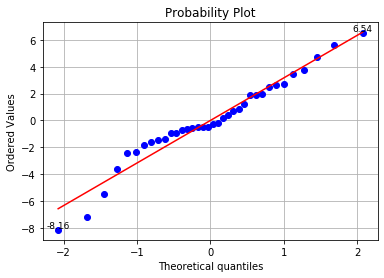

[-8.15833333 -7.2        -5.48333333 -3.6        -2.45833333 -2.38333333
 -1.8        -1.58333333 -1.48333333 -1.38333333 -0.95833333 -0.9
 -0.7        -0.65833333 -0.58333333 -0.48333333 -0.45833333 -0.45833333
 -0.25833333 -0.15833333  0.2         0.4         0.71666667  0.84166667
  1.2         1.9         1.91666667  2.          2.51666667  2.61666667
  2.74166667  3.44166667  3.8         4.7         5.61666667  6.54166667]


In [14]:
# 用qq图进行正态性检验
osm, osr = stats.probplot(res, dist = 'norm', plot = plt)
x1 = osm[0][0]
y1 = osm[1][0]
plt.text(x1, y1, '%.2f' % float(y1), ha = 'center', va = 'bottom',fontsize = 9)
x2 = osm[0][-1]
y2 = osm[1][-1]
plt.text(x2, y2, '%.2f' % float(y2), ha = 'center', va = 'bottom',fontsize = 9)
plt.grid()
plt.show()

print(osm[1])

由上图可以看出，总体上来看，误差分布是近似正态的；qq图在左边稍向下弯曲，这意味着误差分布的左侧尾部比起正态分布的尾部要更厚一些；也就是说，最大的残差不完全如所期望的那样小。  
检测异常值的方法：  
计算标准化残差：$d_{ij} = \frac{e_{ij}}{\sqrt{MS_E}}$。一般地，标准化残差约 68% 落在 ±1 之内，约 95% 落在 ±2 之内，几乎全部落在 ±3 之内。标准化残差的绝对值大于3的残差是一个可能的异常值。  
找一个绝对值最大的数值： -8.16; 
由上述公式得 $d_1 = \frac{e_1}{\sqrt{MS_E}} = \frac{8.16}{\sqrt{10.43}} = 2.53 < 3$，故可说明无明显的异常值，即残差是服从正态分布的。  

【法2】利用Shapiro-Wilk检验来做正态性检验，其原假设：样本数据符合正态分布。（注：适用于小样本）  
利用方法stats.shapiro()检验正态性，输出结果中第一个为统计量，第二个为P值（统计量越接近 1 越表明数据和正态分布拟合的好，P值大于指定的显著性水平，接受原假设，认为样本来自服从正态分布的总体）

In [15]:
# 用Shapiro-Wilk检验进行正态性检验
SW, pVal4 = stats.shapiro(res)
print(round(SW, 2))
print(round(pVal4, 2))

if pVal4 > alpha:
    print('\nAccept the null hypothesis.')
else:
    print('\nSince p-value > 0.05, reject the null null hypothesis') 

0.96
0.26

Accept the null hypothesis.


由上述分析可知，统计量为 0.96，接近 1；且P值为 0.26，大于指定的显著性水平 0.05。故认为残差来自服从正态分布的总体。 

**Q3:** 

In [16]:
# Estimation of Parameter(𝜎2 and 𝜇𝑖 )
mu_1 = np.mean(group1)
mu_2 = np.mean(group2)
mu_3 = np.mean(group3)

mu = [mu_1, mu_2, mu_3]

sse = 0
for i in range(a):
    se = 0
    c_list = data[data[:,0] == (1 + i),1]
    for j in range(n):
        se += (c_list[j] - mu[i]) ** 2
    sse += se
var = round(sse / (a * (n - 1)),2) 
print('Estimate of the population mean：{0}'.format(mu))
print('An estimate of the population variance：{0}'.format(var))

Estimate of the population mean：[116.05833333333334, 100.7, 100.18333333333332]
An estimate of the population variance：10.43


由上述分析可知，3个水平下均值的估计值分别为：116.06，100.70，100.18 

其方差的估计值为：10.43

**Q4:**  
多重比较采用Fisher最小显著性差异（LSD）方法。  
检验：$H_0: \mu_i = \mu_j$ vs $H_1: \mu_i \neq \mu_j$  
检验统计量：$t_0 = \frac{\overline{y}_{i·} - \overline{y}_{j·}}{\sqrt{MS_E·2/n}}$  
当$|\overline{y}_{i·} - \overline{y}_{j·}| > t_{\frac{\alpha}{2},N-a}\sqrt{MS_E·2/n}$时，拒绝原假设，可表明均值对$\mu_i$与$\mu_j$有显著性差异。

In [17]:
#LSD(least significant difference)最小显著差异
def LSD():   
    df = a * (n-1)
    t_value = stats.t(df).isf(alpha / 2)    
    mse = var
    lsd = t_value * math.sqrt(2.0 * mse / n)
    # print(lsd)
    return lsd

for i in range(a):
    for j in range(i + 1,a):
        dist = round(abs(mu[i] - mu[j]), 1)
        print('The difference between group', i + 1, 'and group', j + 1, ': ', dist)
print('Value of LSD: ', round(LSD(),2))
        
cmp = 0
for s in range(a):
    for t in range(s + 1, a):
        lsd = LSD()
        dist = round(abs(mu[s] - mu[t]), 1)
        if(dist < lsd):
            print('No difference between group', s + 1, 'and group', t + 1, ': ')
            cmp += 1
if(cmp == 0):
    print('Reject H0, and there is significant difference in the mean value of any two treatments')

The difference between group 1 and group 2 :  15.4
The difference between group 1 and group 3 :  15.9
The difference between group 2 and group 3 :  0.5
Value of LSD:  2.68
No difference between group 2 and group 3 : 


由于LSD临界值小于任意两种处理均值的差，故拒绝原假设，认为任意两种处理均值存在显著性差异。